In [ ]:
from pydantic import BaseModel
from openai import OpenAI  # OpenAI API
from dotenv import load_dotenv  # Load the API keys from .env
import json
import os

from tqdm.auto import tqdm
import pandas as pd

tqdm.pandas()  # activate the tqdm for pandas


In [ ]:
# now we want to load the API keys from the .env file
load_dotenv(".env")

# check that we have the needed keys
for api_key in ["OPENAI_API_KEY"]:
    if os.getenv(api_key) is not None:
        print(api_key, "loaded")
    else:
        print(api_key, "missing")
        print("Please create a .env file with the corresponding API key")

OPENAI_API_KEY loaded


# OpenAI's API calls

We first need to initialize the OpenAI client.

> If the code bellow doesn't work, make sure that the `OPEN_AI_KEY` is loaded

In [3]:
openai_client = OpenAI();

We will use the cheapest model `gpt-4o-mini` for all the following codes

The messages is the main input of the API. Think of it as the chatbox. `system` messages you can think of as the general instructions, while the `prompt` is the input for those instructions.

In [ ]:
msg = [
    {
        "role": "system",
        "content": "Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The poem should be in the style of a haiku. The text is: ",
    },
    {"role": "user", "content": "crossfit"},
]

In [ ]:
completion = openai_client.chat.completions.create(
    model="gpt-4.1-mini",  # specify the model or even gpt-4.1-nano  o gpt-4o-mini
    messages=msg,
)

In [14]:
completion

ChatCompletion(id='chatcmpl-Ba94aD2KJn7R1AWHXPildqQ0E9TC4', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Iron calls our names,  \nWOD whispers in cold dawn—  \nStrength forged, roots deepen.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1747954384, model='gpt-4.1-mini-2025-04-14', object='chat.completion', service_tier='default', system_fingerprint='fp_79b79be41f', usage=CompletionUsage(completion_tokens=20, prompt_tokens=58, total_tokens=78, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

The variable `completion` will now return with a bunch of data inside (for more detaisl please visit [OpenAI's documentation](https://platform.openai.com/docs/concepts)). 

To get to the text output:

In [15]:
poem = completion.choices[0].message.content
print(poem)

Iron calls our names,  
WOD whispers in cold dawn—  
Strength forged, roots deepen.


You can also get back a `pydantic` type from the [structured outputs](https://platform.openai.com/docs/guides/structured-outputs?api-mode=responses#page-top). For this we have to define some structure for our outputs:

In [ ]:
class Poem(BaseModel):
    title: str
    poem: str
    sad: bool  # potentially define as int from 1-10

I will change the `msg` so that it also tells me if the poem is sad or not. For this, I added a line `sad` and it can take the values True or False.

In [ ]:
msg = [
    {
        "role": "system",
        "content": "Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The poem should be in the style of a haiku. Please also tell me if you think the poem is sad or not and create a title for the poem. The text is: ",
    },
    {"role": "user", "content": "crossfit"},
]

In [ ]:
completion = openai_client.beta.chat.completions.parse(
    model="gpt-4.1-nano",
    messages=msg,
    max_completion_tokens=1024 * 6,  # this sets the max of tokens it can return
    # remember that API calls take money from tokens, so more token more expensive
    response_format=Poem,  # this is the response format we want to get defined before
)

In [19]:
# Get the strutured object
out = completion.choices[0].message.parsed
out

Poem(title='Crossfit Echo', poem='Grains of sweat fall,\nStrength blooms in tired dawns,\nRise, conquer, repeat.', sad=False)

In [20]:
# you can turn the obejct into a dict / json
out.model_dump()

{'title': 'Crossfit Echo',
 'poem': 'Grains of sweat fall,\nStrength blooms in tired dawns,\nRise, conquer, repeat.',
 'sad': False}

In [ ]:
out.model_dump()["title"]

'Crossfit Echo'

In [ ]:
print(out.model_dump()["poem"])

Counting finite gains,
Econ’s endless quest for truth,
Knowledge fuels the mind.


In [21]:
# you can turn the obejct into a dict / json
out.model_dump_json()

'{"title":"Future\'s Gamble","poem":"Graphs and dreams collide,\\nNumbers whisper in the night,\\nChasing fortune\'s light,\\nHope and toil abide.","sad":false}'

## Using data

I have a dataset of the responses of psycologists to comments from patients from [Kaggle](https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations?resource=download)

I want to use the generative AI to clasify the comments of the psycologist as appropiate or not

In [22]:
mental_health = pd.read_csv("data/mental_health.csv")
mental_health.rename(columns={"Context": "Comment"}, inplace=True)
mental_health.dropna(inplace=True)

# take a sample of 20 responses
mental_health = mental_health.sample(20, random_state=1337)
mental_health

,Comment,Response
3296,"My boyfriend is in Ireland for 11 days, and I ...",It sounds like you and your boyfriend are very...
2011,I have so many issues to address. I have a his...,I think this is a very common question that pe...
1683,"After 40 years of being straight, how could I ...",Sexuality is normally formed during adolescenc...
1560,I feel like I took our relationship for grante...,A key factor in a relationship is trust.I'd st...
1267,"I crave attention, companionship, and sex. She...","Hi Hampton,Although I'd bet your wife also wan..."
2895,He said he would try and he never did. It's be...,If your husband is changing his mind about whe...
2697,"I always feel the need to impress people, whet...",It is normal to seek other’s attention and not...
1042,We're in an eight year relationship. My boyfri...,"First, let me extend my compassion to both of ..."
3312,I've gone to a couple therapy sessions so far ...,"Yes, it is completely normal to feel anxious a..."
2788,He is an adolescent. He has peed his pant mult...,"Sounds as though your son is ""pissed off"" abou..."


In [ ]:
def create_msg(row):
    msg = [
        {
            "role": "system",
            "content": "Read the folling comversation between two people. The first person a patient and the second one is a mental health professional. Please rate from 1-5 how appropiate you think is the response of the mental health professional. 1 is not appropiate at all and 5 is very appropiate. Please specify your definition of appropiate. Please provide a confidence level of your rating from 50 (uncertain) to 100 (certain) and show your logical thinking as 'cot' ",
        },
        {
            "role": "user",
            "content": "Patient: "
            + row["Comment"]
            + "\n Mental Health Professional: "
            + row["Response"]
            + "\n",
        },
    ]
    return msg

In [ ]:
mental_health["msg"] = mental_health.progress_apply(create_msg, axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
class Response(BaseModel):
    rating: int
    confidence: int
    definition: str
    cot: list[str]

In [ ]:
def structured_API_call(msg):
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=msg,
        max_completion_tokens=1024 * 6,  # Most likely will need this high for the cot
        response_format=Response,  # this is the response format we want to get defined before
    )

    return completion.choices[0].message.parsed

In [ ]:
answers = mental_health["msg"].progress_apply(structured_API_call)

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
answers

3296    rating=4 confidence=85 definition="Appropriate...
2011    rating=5 confidence=95 definition="Appropriate...
1683    rating=3 confidence=80 definition="I define ap...
1560    rating=4 confidence=85 definition='Appropriate...
1267    rating=5 confidence=90 definition="Appropriate...
2895    rating=4 confidence=85 definition='I define ap...
2697    rating=4 confidence=85 definition='An appropri...
1042    rating=5 confidence=90 definition='Appropriate...
3312    rating=5 confidence=90 definition="Appropriate...
2788    rating=4 confidence=85 definition="Appropriate...
606     rating=4 confidence=90 definition="Appropriate...
1443    rating=5 confidence=90 definition="Appropriate...
2576    rating=4 confidence=85 definition="Appropriate...
1078    rating=1 confidence=70 definition="The appropr...
1948    rating=5 confidence=90 definition="Appropriate...
73      rating=5 confidence=90 definition='Appropriate...
2687    rating=4 confidence=85 definition='Appropriate...
1606    rating

In [ ]:
ratings = [obj.rating for obj in answers]
confidence = [obj.confidence for obj in answers]
definition = [obj.definition for obj in answers]
cot = [obj.cot for obj in answers]

mental_health["rating"] = ratings
mental_health["confidence"] = confidence
mental_health["definition"] = definition
mental_health["cot"] = cot

In [30]:
mental_health

,Comment,Response,msg,rating,confidence,definition,cot
3296,"My boyfriend is in Ireland for 11 days, and I ...",It sounds like you and your boyfriend are very...,"[{'role': 'system', 'content': 'Read the folli...",4,85,Appropriate responses in a therapeutic context...,[The mental health professional acknowledges t...
2011,I have so many issues to address. I have a his...,I think this is a very common question that pe...,"[{'role': 'system', 'content': 'Read the folli...",5,95,Appropriate responses from mental health profe...,[The mental health professional validates the ...
1683,"After 40 years of being straight, how could I ...",Sexuality is normally formed during adolescenc...,"[{'role': 'system', 'content': 'Read the folli...",3,80,I define appropriate as a response that is res...,[The mental health professional provides an in...
1560,I feel like I took our relationship for grante...,A key factor in a relationship is trust.I'd st...,"[{'role': 'system', 'content': 'Read the folli...",4,85,Appropriate refers to the relevance and helpfu...,[The mental health professional acknowledges a...
1267,"I crave attention, companionship, and sex. She...","Hi Hampton,Although I'd bet your wife also wan...","[{'role': 'system', 'content': 'Read the folli...",5,90,Appropriate responses from mental health profe...,[The mental health professional starts by ackn...
2895,He said he would try and he never did. It's be...,If your husband is changing his mind about whe...,"[{'role': 'system', 'content': 'Read the folli...",4,85,I define appropriate responses as those that p...,[The mental health professional acknowledges t...
2697,"I always feel the need to impress people, whet...",It is normal to seek other’s attention and not...,"[{'role': 'system', 'content': 'Read the folli...",4,85,An appropriate response in a therapeutic conte...,[The mental health professional starts by norm...
1042,We're in an eight year relationship. My boyfri...,"First, let me extend my compassion to both of ...","[{'role': 'system', 'content': 'Read the folli...",5,90,Appropriate responses are those that show unde...,[The mental health professional begins with co...
3312,I've gone to a couple therapy sessions so far ...,"Yes, it is completely normal to feel anxious a...","[{'role': 'system', 'content': 'Read the folli...",5,90,Appropriateness in this context means respondi...,[The mental health professional acknowledged t...
2788,He is an adolescent. He has peed his pant mult...,"Sounds as though your son is ""pissed off"" abou...","[{'role': 'system', 'content': 'Read the folli...",4,85,Appropriate responses are those that demonstra...,[The mental health professional begins by empa...


<Axes: xlabel='rating'>

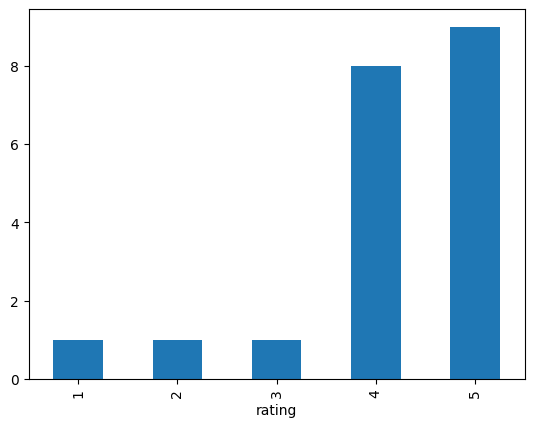

In [ ]:
mental_health["rating"].value_counts().sort_index().plot(kind="bar")

In [ ]:
# what where the ones with lower ratings?
low_ratings = mental_health[mental_health["rating"] < 3]

for row in low_ratings.iterrows():
    print("Comment: ", row[1]["Comment"])
    print("Response: ", row[1]["Response"])
    print("Rating: ", row[1]["rating"])
    print("Definition: ", row[1]["definition"])
    print("Confidence: ", row[1]["confidence"])
    print("Cot: ", row[1]["cot"])
    print("\n")

Comment:  I've pretty much been on my own since day one, I'm a middle child of five, and I can't seem to put my trust in anyone. It took me four years to finally open up a little to my best friend. Every time I realize that I have feelings for someone, I freak out and never talk to them again. I really want some help.
Response:  One way to concentrate is that if your mind starts to wonder then remind yourself to bring your attention back.Start with short time spans of expecting yourself to concentrate.  You'll more likely succeed with concentrating with small time spans than longer ones.Once you start seeing your success, this will motivate you to try increasing the length to expect yourself to concentrate.The task of self-reminding is the same, whether for long or short time periods.Also, before starting this exercise ask your medical doctor if the problem can be related to a physical health problem.If there is, then have the possibility ruled out that your difficulty concentrating co

# Simple AI Agent with ReAct prompts

[AI Agents](https://cloud.google.com/discover/what-are-ai-agents?hl=en) have been popular in 2024-25. 

Agents are specialized algorithms with a defined set of `tools` or functions to finish an specific task from a prompt. The brain of this agent is an LLM of your choice, however it's prefered that these agents have a big context window.

A simple framework for an agent is the *ReAct* prompt, where the model first reasons and then acts. 

In the following example we will again use OpenAI's API and suppose that our agent has a `tool` that allows it to search the web. So the idea is that we will give it a task and the agent will then think of the next step, look for it on the web, extract that info and prepare a next step, until he has reached his answer.

> This example has been taken from Kaggle + Google Intensive AI course in 2025 prompting [notebook](https://www.kaggle.com/code/markishere/day-1-prompting). For more details on how to tailor your prompts please review the document in Prompt Engineering pdf @ `media/Prompt Engineering_google.pdf`

Please review the following prompt, and notice how it provides one-shot examples to improve the performance of the model.

In [36]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action
<search>Milhouse</search>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action
<finish>1,800 to 7,000 ft</finish>
"""

example3 = """Question
Where does the US president live during his term?

Thought
Presidents of the US live in the White House during their term.

Action
<finish>the White House</finish>
"""

For this we will need keep a *history* and feed that into the input of a OpenAI prompt.

In [ ]:
history = [
    {"role": "system", "content": model_instructions + example1 + example2 + example3},
    {
        "role": "user",
        "content": "Question \n Where does the youngest person to win the Economimcs 2024 Nobel Prize work at?",
    },
]

In [ ]:
response = openai_client.responses.create(
    model="gpt-4.1-nano",
    input=history,
    temperature=0.1,
)
print(response.output_text)

Thought
The youngest person to win the Nobel Prize in Economics in 2024 is likely to be a notable economist. I need to find information about the 2024 Nobel laureate in Economics and their current affiliation.

Action
<search>2024 Nobel Prize in Economics</search>


Now let's do like the agent used the `tool` to look into the [Novel Prize Website](https://www.nobelprize.org/prizes/economic-sciences/2024/popular-information/) we can get

> This year’s laureates have provided new insights into why there are such vast differences in prosperity between nations. One important explanation is persistent differences in societal institutions. By examining the various political and economic systems introduced by European colonisers, Daron Acemoglu, Simon Johnson and James A. Robinson have been able to demonstrate a relationship between institutions and prosperity. They have also developed theoretical tools that can explain why differences in institutions persist and how institutions can change.

Which we can add to the history:

In [ ]:
history += [{"role": "assistant", "content": response.output_text}]
history += [
    {
        "role": "user",
        "content": "here is what I found on the web: \n\n"
        + "This year’s laureates have provided new insights into why there are such vast differences in prosperity between nations. One important explanation is persistent differences in societal institutions. By examining the various political and economic systems introduced by European colonisers, Daron Acemoglu, Simon Johnson and James A. Robinson have been able to demonstrate a relationship between institutions and prosperity. They have also developed theoretical tools that can explain why differences in institutions persist and how institutions can change.",
    }
]

In [ ]:
# with the updated history ask it again
response = openai_client.responses.create(
    model="gpt-4.1-nano",
    input=history,
    temperature=0.1,
)
print(response.output_text)

Thought
The laureates mentioned are Daron Acemoglu, Simon Johnson, and James A. Robinson. Since the question asks about the youngest person among them, I need to determine their ages and current affiliations.

Action
<search>Daron Acemoglu</search>


From his [wikipedia](https://en.wikipedia.org/wiki/Daron_Acemoglu) we can see:
> Daron Acemoglu was born in September 3, 1967 (age 57) in Istanbul, Turkey. Works history: London School of Economics (1989–1993) Massachusetts Institute of Technology (1993–present)|

In [ ]:
# update history with the new response
history += [{"role": "assistant", "content": response.output_text}]
history += [
    {
        "role": "user",
        "content": "Daron Acemoglu was born in September 3, 1967 (age 57) in Istanbul, Turkey. Works history: London School of Economics (1989–1993) Massachusetts Institute of Technology (1993–present)",
    }
]

In [ ]:
# with the updated history ask it again
response = openai_client.responses.create(
    model="gpt-4.1-nano",
    input=history,
    temperature=0.1,
)
print(response.output_text)

Thought
Daron Acemoglu is currently 57 years old and works at the Massachusetts Institute of Technology. I need to check the ages and affiliations of Simon Johnson and James A. Robinson to determine who is the youngest.

Action
<search>Simon Johnson economist</search>


Now if we go to [Simon Johnson wiki page](https://en.wikipedia.org/wiki/Simon_Johnson_(economist))
> Simon Johnson was born in January 16, 1963 (age 62) Sheffield, United Kingdom and his work history is the following: From 1989 to 1991, Johnson was a junior scholar at Harvard University, where he was a member of the Harvard Academy for International and Area Studies and a fellow of its Russian Research Center. From 1991 to 1997, he taught at the Fuqua School of Business at Duke University, where he was an assistant professor till 1995, and an associate professor till 1997; he also directed its Center for Manager Development in St Petersburg, Russia from 1993 to 1995. He joined the faculty of MIT in 1997, and was tenured in 2002. At MIT, he is a research affiliate at Blueprint Labs, co-directs MIT's Shaping the Future of Work Initiative, and heads its Global Economics and Management Group.

In [ ]:
# update history with the new response
history += [{"role": "assistant", "content": response.output_text}]
history += [
    {
        "role": "user",
        "content": "Simon Johnson was born in January 16, 1963 (age 62) Sheffield, United Kingdom and his work history is the following: From 1989 to 1991, Johnson was a junior scholar at Harvard University, where he was a member of the Harvard Academy for International and Area Studies and a fellow of its Russian Research Center. From 1991 to 1997, he taught at the Fuqua School of Business at Duke University, where he was an assistant professor till 1995, and an associate professor till 1997; he also directed its Center for Manager Development in St Petersburg, Russia from 1993 to 1995. He joined the faculty of MIT in 1997, and was tenured in 2002. At MIT, he is a research affiliate at Blueprint Labs, co-directs MIT's Shaping the Future of Work Initiative, and heads its Global Economics and Management Group.",
    }
]

In [ ]:
# with the updated history ask it again
response = openai_client.responses.create(
    model="gpt-4.1-nano", input=history, temperature=0.1
)
print(response.output_text)

Thought
Simon Johnson is 62 years old and works at MIT. Now, I will check James A. Robinson's age and affiliation to compare.

Action
<search>James A. Robinson economist</search>


[James A. Robinson wiki](https://en.wikipedia.org/wiki/James_A._Robinson)
> James A. Robinson was born in 1960 (age 64–65) in Chelmsford, Essex, United Kingdom ans his work history is In 2004, Robinson was appointed Associate Professor of Government at Harvard University. He later held named chair positions at Harvard, first as the David Florence Professor of Government (2009–2014) and later as the Wilbur A. Cowett Professor of Government (2014–2015). On 1 July 2015, he was appointed as one of nine University Professors at the Harris School of Public Policy Studies of the University of Chicago. He also holds the title Reverend Dr. Richard L. Pearson Professor of Global Conflict Studies. On 9 May 2016, Professor Robinson was awarded an honorary doctorate by the National University of Mongolia during his first visit to the country.

In [ ]:
# update history with the new response
history += [{"role": "assistant", "content": response.output_text}]
history += [
    {
        "role": "user",
        "content": "James A. Robinson was born in 1960 (age 64–65) in Chelmsford, Essex, United Kingdom ans his work history is In 2004, Robinson was appointed Associate Professor of Government at Harvard University. He later held named chair positions at Harvard, first as the David Florence Professor of Government (2009–2014) and later as the Wilbur A. Cowett Professor of Government (2014–2015). On 1 July 2015, he was appointed as one of nine University Professors at the Harris School of Public Policy Studies of the University of Chicago. He also holds the title Reverend Dr. Richard L. Pearson Professor of Global Conflict Studies. On 9 May 2016, Professor Robinson was awarded an honorary doctorate by the National University of Mongolia during his first visit to the country.",
    }
]

In [ ]:
# with the updated history ask it again
response = openai_client.responses.create(
    model="gpt-4.1-nano", input=history, temperature=0.1
)
print(response.output_text)

Thought
James A. Robinson is approximately 64–65 years old and works at the University of Chicago. Comparing ages: Daron Acemoglu is 57, Simon Johnson is 62, and James A. Robinson is around 64–65. Therefore, Daron Acemoglu is the youngest among them.

Answer
<finish>Daron Acemoglu is the youngest person to win the Economics 2024 Nobel Prize, and he works at the Massachusetts Institute of Technology (MIT).</finish>


At this point you should have returned an answer of who is the youngest (Daron Acemoglu) and he works at MIT.

In this example we did the web searching for the model, but you could also have created a `tool` or a function so that the agent can then use. For more info in AI agents please see the other pdf from the Generative AI Intesive course @ `media/ai_agents_google.pdf`

# Extra: Google AI with Gemini

In [4]:
# Gemini
from google import genai
from google.genai import types

In [5]:
# now we want to load the API keys from the .env file
load_dotenv(".env")

# check that we have the needed keys
for api_key in ["GEMINI_API"]:
    if os.getenv(api_key) is not None:
        print(api_key, "loaded")
    else:
        print(api_key, "missing")
        print("Please create a .env file with the corresponding API key")

GEMINI_API loaded


In [6]:
gemini_client = genai.Client(api_key=os.getenv("GEMINI_API"));

Google API has more limited options for `pydantic`

In [7]:
class PoemGemini(BaseModel):
    title: str
    poem: str
    sad: bool  # potentially define as int from 1-10

In [8]:
system_instruction = """Write me a poam about the topic of the following text. It should be a short poem, no more than 4 lines. The poem should be in the style of a haiku. The text is: """

# This is how you set the parameters for the generation
generation_config = types.GenerateContentConfig(
    temperature=0.7,
    top_p=0.95,
    top_k=5,
    max_output_tokens=1024 * 10,
    response_schema=PoemGemini,
    response_mime_type="application/json",  # this then returns a json object
    system_instruction=system_instruction,
)

In [9]:
model_out = gemini_client.models.generate_content(
    model="gemini-2.0-flash",  # here always use this one since it's free
    config=generation_config,
    contents="crossfit",
)

In [15]:
model_out.text

'{\n  "title": "Crossfit Haiku",\n  "poem": "Heavy weights arise,\\nMuscles burn, a primal scream,\\nBody redefined.",\n  "sad": false\n}'

Note how it returns a sort of json structure. So we can extract that json using the following functions

In [19]:
structured_out = json.loads(model_out.text)
structured_out

{'title': 'Crossfit Haiku',
 'poem': 'Heavy weights arise,\nMuscles burn, a primal scream,\nBody redefined.',
 'sad': False}